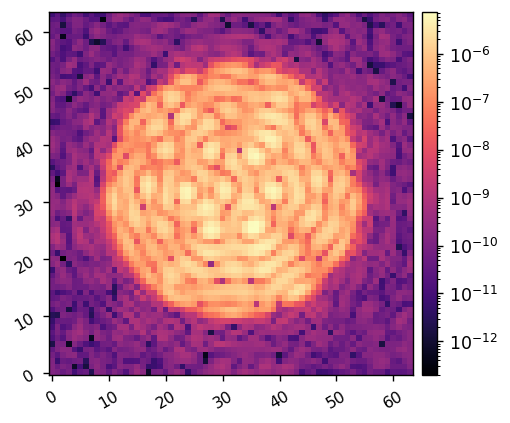

In [18]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

from roman_cgi_iefc_2.poppy_roman_cgi_phasec import cgi
from roman_cgi_iefc_2 import iefc_utils as iefcu
from roman_cgi_iefc_2 import pwp, efc

import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

def init():
    hlci = cgi.CGI_POPPY(polaxis=0, use_opds=True, use_fieldstop=True, quiet=True, ngpus=1/4)
    hlci.set_dm1(2*dm1_flatmap)
    hlci.set_dm2(2*dm2_flatmap)
    return hlci

hlci = init()

ref_psf = hlci.calc_psf()[-1]
misc.myimshow(ref_psf.intensity, lognorm=True)

npsf = hlci.npsf
Nact = hlci.Nact

(calc_psf pid=93369) Propagating wavelength 575.000 nm.
All PSFs calculated in 0.480s
(calc_psf pid=93369) PSF calculated in 0.444s


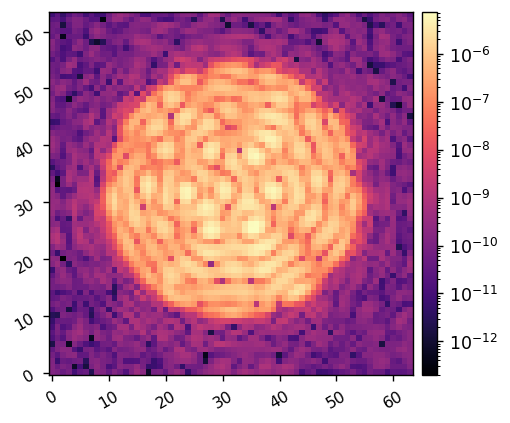

In [8]:
hlci = init()

ref_psf = hlci.calc_psfs()[0][-1]
misc.myimshow(ref_psf.intensity, lognorm=True)

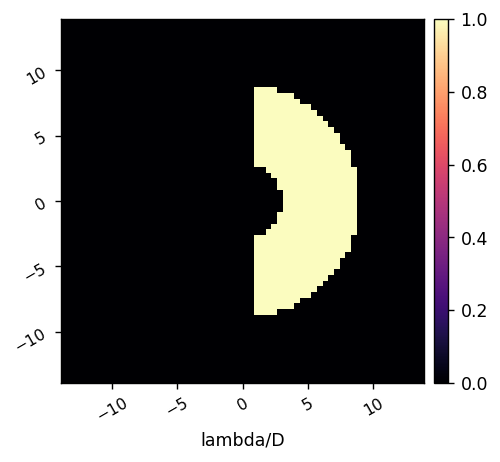

In [9]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 9

# Create the mask that is used to select which region to make dark.
dh_params = {'inner_radius' : iwa, 'outer_radius' : owa, 'edge_position' : edge, 'direction' : '+x'}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params)
nmask = dh_mask.sum()

misc.myimshow(dh_mask, pxscl=hlci.psf_pixelscale_lamD)

In [10]:
reload(efc)

hlci = cgi.CGI_POPPY(polaxis=0, use_opds=True, use_fieldstop=True, quiet=True, ngpus=1/2)
hlci.set_dm1(2*dm1_flatmap)
hlci.set_dm2(2*dm2_flatmap)

jac = efc.build_jacobian(hlci, 1e-9, dh_mask)

Building Jacobian.
	Calculating response for mode 0. Elapsed time=0.000 sec.
	Calculating response for mode 1. Elapsed time=1.863 sec.
	Calculating response for mode 2. Elapsed time=2.556 sec.
	Calculating response for mode 3. Elapsed time=3.226 sec.
	Calculating response for mode 4. Elapsed time=3.890 sec.
	Calculating response for mode 5. Elapsed time=4.550 sec.
	Calculating response for mode 6. Elapsed time=5.207 sec.
	Calculating response for mode 7. Elapsed time=5.878 sec.
	Calculating response for mode 8. Elapsed time=6.536 sec.
	Calculating response for mode 9. Elapsed time=7.197 sec.
	Calculating response for mode 10. Elapsed time=7.852 sec.
	Calculating response for mode 11. Elapsed time=8.495 sec.
	Calculating response for mode 12. Elapsed time=9.136 sec.
	Calculating response for mode 13. Elapsed time=9.766 sec.
	Calculating response for mode 14. Elapsed time=10.405 sec.


KeyboardInterrupt: 

In [138]:
iefcu.save_pickle(data_dir/'jacobians'/'jac_opds_right39', jac, quiet=False)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians/jac_opds_right39


In [11]:
jac = iefcu.load_pickle(data_dir/'jacobians'/'jac_opds_right39')
jac.shape

(1044, 2304)

Generating probe with amplitude=5.750e-09, radius=12.0, phase=0.000, offset=(10.0,10.0), with discontinuity along x axis.


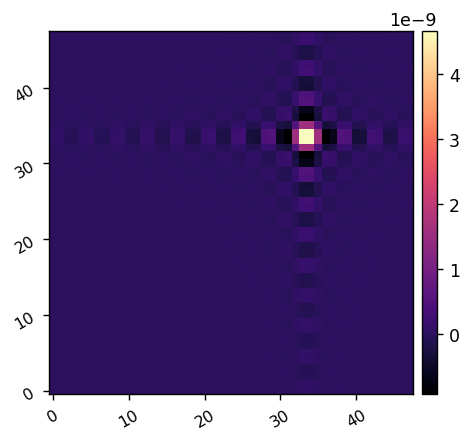

Generating probe with amplitude=5.750e-09, radius=12.0, phase=1.047, offset=(10.0,10.0), with discontinuity along y axis.


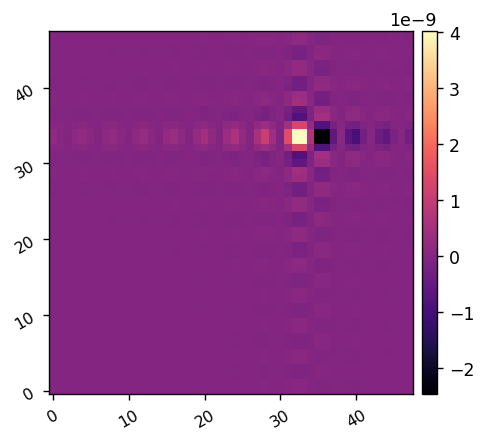

Generating probe with amplitude=5.750e-09, radius=12.0, phase=2.094, offset=(10.0,10.0), with discontinuity along x axis.


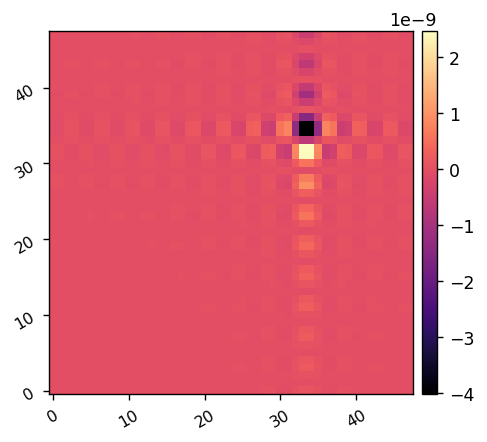

In [26]:
reload(pwp)

Npairs = 3
probe_amp = 0.01*hlci.wavelength_c.value
probe_radius = 12
probe_offset = (10,10)

probes = pwp.create_sinc_probes(Npairs, Nact, probe_amp, probe_radius, probe_offset, display=True)


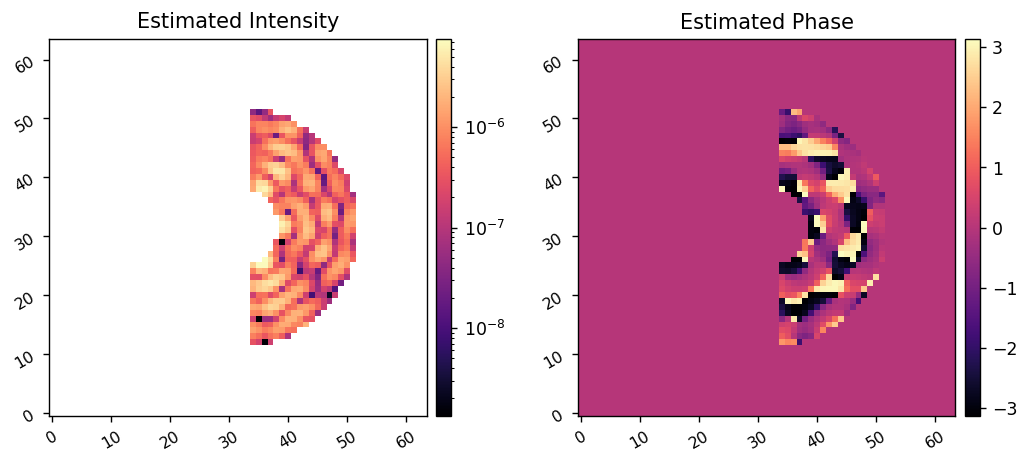

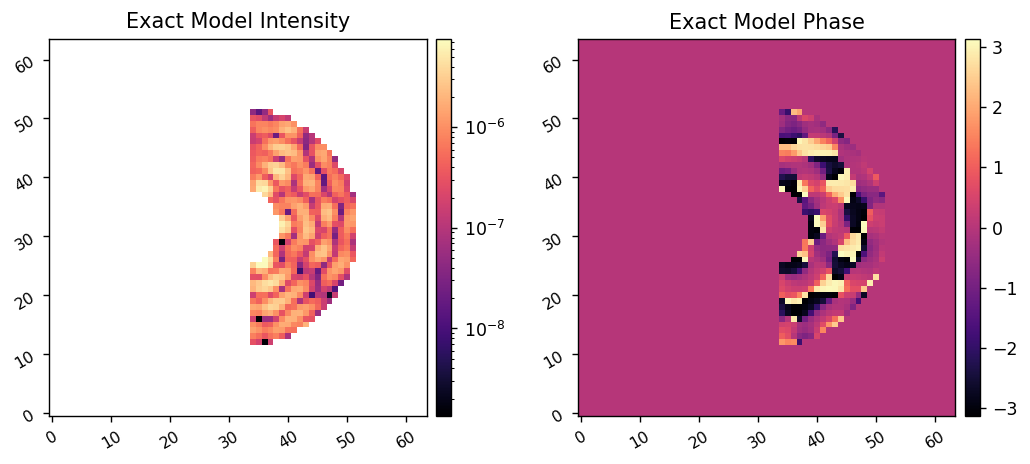

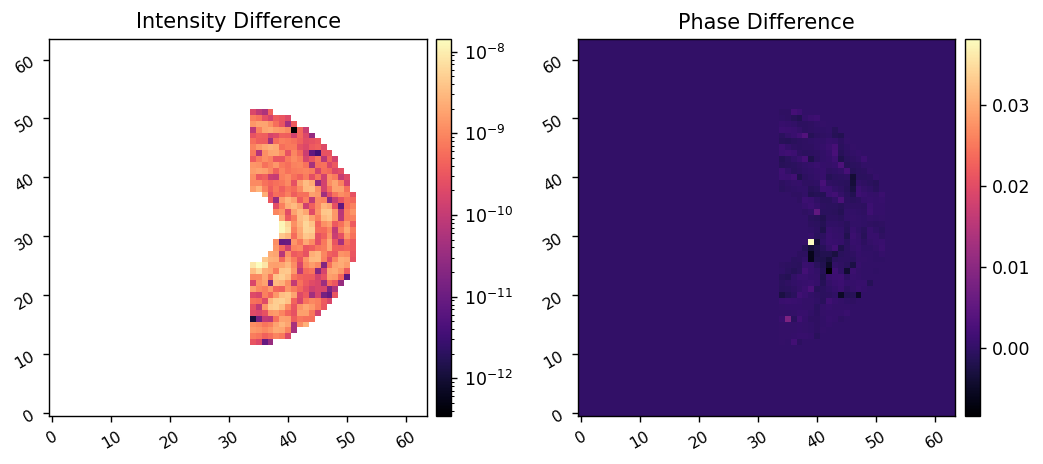

In [29]:
reload(pwp)

hlci = init()

E_est = pwp.run_pwp(hlci, probes, jac, dh_mask)

misc.myimshow2(cp.abs(E_est)**2, cp.angle(E_est), 
               'Estimated Intensity', 'Estimated Phase', lognorm1=True)
misc.myimshow2(ref_psf.intensity.get()*dh_mask, ref_psf.phase.get()*dh_mask, 
               'Exact Model Intensity', 'Exact Model Phase', lognorm1=True)
misc.myimshow2(abs(ref_psf.intensity.get()*dh_mask-np.abs(E_est.get())**2), ref_psf.phase.get()*dh_mask - np.angle(E_est.get()),
               'Intensity Difference', 'Phase Difference',
               lognorm1=True)